In [58]:
%matplotlib nbagg
import photodiag
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import json
import os

from scipy.special import erf
from scipy.optimize import curve_fit

palm = photodiag.PalmSetup({'0': 'SAROP11-PALMK118:CH1_BUFFER', '1': 'SAROP11-PALMK118:CH2_BUFFER'},
                 noise_range=[0, 250],
                 energy_range=np.linspace(900, 1350, 2000))

palm.load_etof_calib(f'/sf/alvra/data/p17589/res/PhotoDiag/scan_info/2019-03-25_11:53:57.palm_etof')
%matplotlib nbagg

In [59]:
def LoadData(fn):
    with h5.File(fn, 'r') as f:
        TOF = -f['SAROP11-PALMK118:CH2_BUFFER/data'][:]
        uTOF = -f['SAROP11-PALMK118:CH1_BUFFER/data'][:]
        PulseIds = f['SAROP11-PALMK118:CH2_BUFFER/pulse_id'][:]
#         index_laser = PulseIds%4 == 0
# for 25Hz gated 5 Hz use the following
#        index_laser = np.logical_and(PulseIds%4 == 0, PulseIds%20 != 0)
# for 50Hz gated 10 Hz use the following
#         index_laser = np.logical_and(PulseIds%2 == 0, PulseIds%10 != 0)
# for 50Hz the following
        index_laser = PulseIds%2 == 0
# for 12.5 Hz only use the following
#        index_laser = PulseIds%8 == 0
# for 12.5 Hz only use the following
#        index_laser = PulseIds%2 == 0
# for 25 Hz operation
#         index_laser = np.logical_and(PulseIds%4==0, PulseIds !=0)

#         TOFM = TOF.mean(axis=0)
        eVIntP = palm.etofs['1'].convert(
        input_data=TOF[index_laser],
        interp_energy=palm.energy_range
        )
        eVIntUp = palm.etofs['0'].convert(
        input_data=uTOF[index_laser],
        interp_energy=palm.energy_range
        )
#         Str_data = TOF[index_laser]
#         Ustr_data = TOF[index_no_laser]
#         DiodePump = Diode[index_laser]
#         DiodeUnpump = Diode[index_no_laser]
    return(eVIntP, eVIntUp,TOF[index_laser], uTOF[index_laser])

Change fn below, if the following error is displayed:
JSONDecodeError: Expecting value: line 1 column 1 (char 0)
retry - its just the file isn't yet where ra looks

In [155]:
# load data from json file
fn  = '/sf/alvra/data/p17589/res/PhotoDiag/scan_info/PALM_scan_207_scan_info.json'
#fn  = '/sf/alvra/data/p17803/res/PhotoDiag/scan_info/PALM_scan_122_scan_info.json'
with open(fn) as f:
    data = json.load(f)
numFiles = len(data['scan_files'])
StagePOS = data['scan_values'][:]

eVIntP = []
eVIntUp = []
wf_str = []
wf_ref = []

for i in range(0,numFiles):   
    (tmpP, tmpUp, tmpwf_str, tmpwf_ref) = LoadData(str(data['scan_files'][i][0]))
    eVIntP.append(tmpP)
    eVIntUp.append(tmpUp)
    wf_str.append(tmpwf_str)
    wf_ref.append(tmpwf_ref)
    
eVIntP = np.array(eVIntP)
eVIntUp = np.array(eVIntUp)
print(eVIntP.shape)

wf_str = np.array(wf_str)
wf_ref = np.array(wf_ref)
StagePOS = np.array(StagePOS)
Stagefs = (StagePOS[:,0]*1e-3*2/3e8)*1e15

(31, 100, 2000)
(31, 100, 2000)


In [144]:
#This is just to check the loading of the data was correct.
wf_str.shape

(13, 100, 2000)

In [156]:
delays, pulse_lengths,(input_data, lags, corr_res_uncut, corr_results) = palm.process({'0': wf_ref[0,:,:], '1': wf_str[0,:,:]}, noise_thr=0, debug=True, jacobian=False, peak='max')

<IPython.core.display.Javascript object>


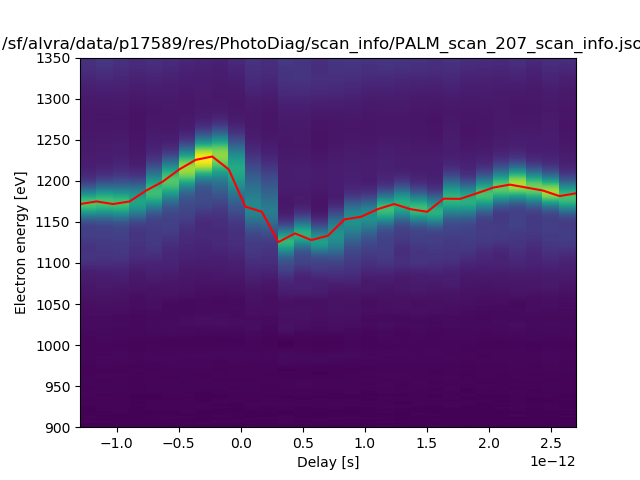

In [157]:
t0 = 5.40955e-10
fig = plt.figure()
plt.pcolormesh(StagePOS[:,0]-t0, palm.energy_range, np.transpose(eVIntP.mean(axis=1)))
plt.plot(StagePOS[:,0]-t0, palm.energy_range[np.argmax(np.transpose(eVIntP.mean(axis=1)),axis =0)], color = 'r')
plt.xlabel('Delay [s]')
plt.ylabel('Electron energy [eV]')
plt.title(fn)
plt.show()
#fig.set_size_inches(18.5, 10.5) # Why Chris Why ? Also inches ? really ?
# fig.savefig('PALM_setup_scan_043.png', format='png')

In [158]:
# define the fitfunction
def fitfunc(x, a, b, c, d, e, f):
    return a + b*np.exp(-(c-x)**2/np.abs(d)**2)*np.sin(e*x + f)  

In [159]:
# testfunction
a = 1170
b = 150
c = 5.312e-10
d = 2e-12
e = 3e12
f = 4

testfunction =  a + b*np.exp(-(c-StagePOS[:,0])**2/np.abs(d)**2)*np.sin(e*StagePOS[:,0] + f)
#print(testfunction)
#print(StagePOS[:,0])

In [160]:
#Now fit with fit function (defined above)
param_bounds = ([950,10,5.4e-10,1e-13,2e12,0],[1250,500,5.5e-10,3e-12,4e12,np.inf])
parameters,extras = curve_fit(fitfunc,StagePOS[:,0],palm.energy_range[np.argmax(np.transpose(eVIntP.mean(axis=1)),axis =0)], 
                              p0 = [1125, 150, 5.4e-10,3e-12,2.8e12,1])#,bounds=param_bounds)
# make the derivative 
dx = StagePOS[1,0]-StagePOS[2,0]
d_fitfunc_dx = np.gradient(fitfunc(StagePOS[:,0],*parameters), dx)/np.max(np.gradient(fitfunc(StagePOS[:,0],*parameters), dx))

max_y = np.max(np.gradient(fitfunc(StagePOS[:,0],*parameters)))  # Find the maximum y value
max_x = np.argmin(np.gradient(fitfunc(StagePOS[:,0],*parameters)))  # Find the maximum y value

# t0 from the phase fit 
t0_from_phase = parameters[2] + (parameters[4]*parameters[5])**-1 

#print(max_x, max_y)
print(t0_from_phase)
print(parameters[2])


5.410646999651102e-10
5.410630956979969e-10


In [161]:
#print(param_bounds)
print(dx)
print(parameters)
print(parameters[0] + d_fitfunc_dx)

-1.3333333333327083e-13
[ 1.17824474e+03  4.37450830e+02  5.41063096e-10 -5.43996354e-13
  4.96705935e+11  1.25494291e+03]
[1178.217602   1178.19739113 1178.13900584 1178.04347782 1177.92434138
 1177.83405408 1177.86026867 1178.08039717 1178.48751301 1178.94685711
 1179.24473551 1179.21969653 1178.87763963 1178.38989766 1177.974832
 1177.76520901 1177.76075382 1177.87537933 1178.01499325 1178.12453076
 1178.19095407 1178.22395799 1178.23776105 1178.24269275 1178.2442119
 1178.24461779 1178.24471226 1178.24473147 1178.24473489 1178.24473542
 1178.24473549]


<IPython.core.display.Javascript object>


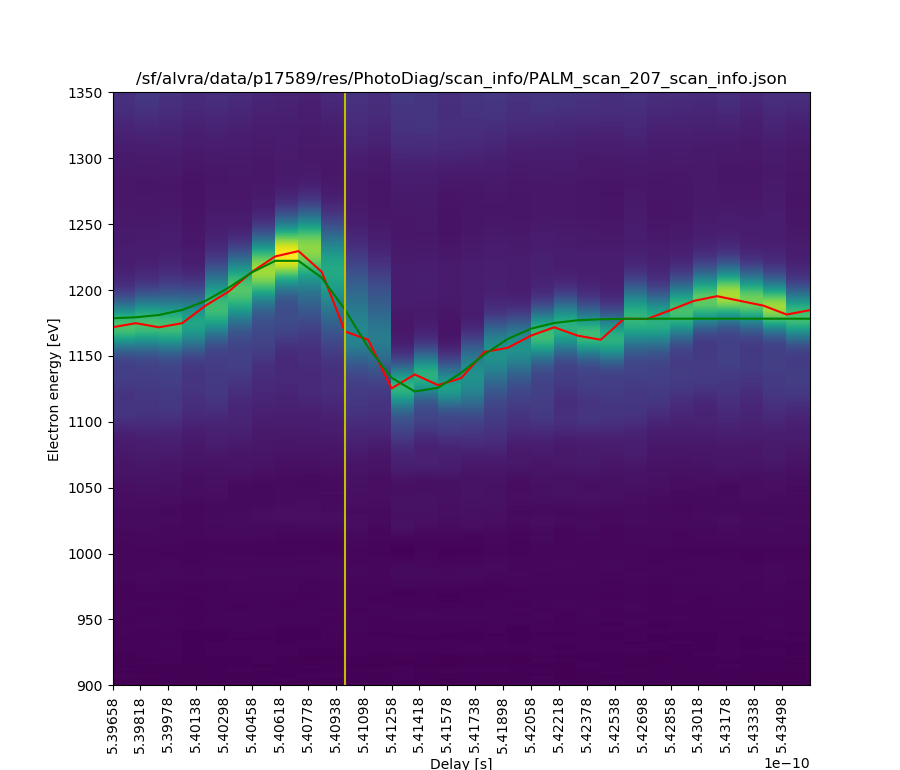

T0_derivative max = 540.9917 ps
T0_phase = 541.0647 ps
(T0_deriv-T0_phase) = -73.0338 fs


In [162]:
plt.figure(figsize = (9,7.7))

#plt.subplot(121)

plt.pcolormesh(StagePOS[:,0], palm.energy_range, np.transpose(eVIntP.mean(axis=1)))
plt.plot(StagePOS[:,0], palm.energy_range[np.argmax(np.transpose(eVIntP.mean(axis=1)),axis =0)], color = 'r')
plt.plot(StagePOS[:,0], fitfunc(StagePOS[:,0],*parameters),color = 'g')
plt.axvline(StagePOS[max_x,0],color = 'y')
#plt.axhline(parameters[0])
#plt.axvline(x=71.98, color = 'w')
#plt.axvline(x=541.00e-12, color = 'w')
# plt.axvline(x=531.63e-12, color = 'y')   #Reference from previous scan

#plt.pcolormesh(StagePOS[:,0], palm.energy_range, COM)
#plt.pcolormesh(Stagefs-535500, palm.energy_range, np.transpose(eVIntP.mean(axis=1)))

# plt.ylim([4900, 5100])
# plt.ylim([5600, 6100])
# plt.xlim([80.25, 80.45])
# plt.xlim([-500e-15, 800e-15])
plt.xlabel('Delay [s]')
plt.ylabel('Electron energy [eV]')
plt.title(fn)
plt.xticks(np.arange(np.min(StagePOS[:,0]),np.max(StagePOS[:,0]),step=0.04*(np.max(StagePOS[:,0])-np.min(StagePOS[:,0]))),rotation='vertical')

#plt.subplot(122)

#plt.plot(StagePOS[:,0], palm.energy_range[np.argmax(np.transpose(eVIntP.mean(axis=1)),axis=0)], color = 'r')
#plt.plot(StagePOS[:,0], testfunction, color = 'b')
#plt.plot(StagePOS[:,0], parameters[0] + parameters[1]*d_fitfunc_dx/10, color = 'm')
#plt.plot(StagePOS[:,0], fitfunc(StagePOS[:,0],*parameters),color = 'g')
#plt.axvline(StagePOS[max_x,0])
#plt.axvline(t0_from_phase,color = 'y')
#plt.axhline(parameters[0])

#print( parameters)

print("T0_derivative max =", np.round(StagePOS[max_x,0]/1e-12,4),"ps")
print("T0_phase =", np.round(t0_from_phase/1e-12,4),"ps")
print("(T0_deriv-T0_phase) =",np.round((StagePOS[max_x,0] - t0_from_phase)/1e-15,4),"fs")


In [57]:
StagePOS[22]

array([5.40116666e-10])

In [ ]:
eVIntP.shape

In [ ]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(palm.energy_range, eVIntP[22,10,:],label='Unstreaked')
plt.plot(palm.energy_range, eVIntUp[22,10,:],label='Streaked')
plt.xlim([0,5100])

plt.subplot(2,1,2)
plt.plot(palm.energy_range, eVIntP[22].mean(axis=0),label='Unstreaked')
plt.plot(palm.energy_range, eVIntUp[22].mean(axis=0),label='Unstreaked')
plt.xlim([0,5100])
plt.ylim([0, 0.02])
plt.legend()

In [ ]:
wf_ref.shape

In [ ]:
plt.figure()
plt.plot(wf_ref[1,1,:])
plt.xlim([700, 900])